# Multi-period OPF example

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from nygrid.run_nygrid import NYGrid

In [2]:
# Set up directories
cwd = os.getcwd()
if 'examples' in cwd:
    parent_dir = os.path.dirname(cwd)
    data_dir = os.path.join(parent_dir, 'data')
else:
    data_dir = os.path.join(cwd, 'data')

grid_data_dir = os.path.join(data_dir, 'grid')
if not os.path.exists(grid_data_dir):
    raise FileNotFoundError('Grid data directory not found.')

print('Grid data directory: {}'.format(grid_data_dir))

fig_dir = os.path.join(os.path.dirname(data_dir), 'figures')
print('Figure directory: {}'.format(fig_dir))

results_dir = os.path.join(os.path.dirname(data_dir), 'results')
print('Results directory: {}'.format(results_dir))

Grid data directory: D:\EERL\OneMet\NYgrid-python\data\grid
Figure directory: D:\EERL\OneMet\NYgrid-python\figures
Results directory: D:\EERL\OneMet\NYgrid-python\results


## Read grid data

In [34]:
start_date = datetime(2018, 1, 1, 0, 0, 0)
end_date = datetime(2019, 1, 1, 0, 0, 0)
timestamp_list = pd.date_range(start_date, end_date, freq='1D')

# Read load profile
load_profile = pd.read_csv(os.path.join(grid_data_dir, f'load_profile_{start_date.year}.csv'), 
                           parse_dates=['TimeStamp'], index_col='TimeStamp')
load_profile.index.freq = 'H'


# Read generation profile
gen_profile = pd.read_csv(os.path.join(grid_data_dir, f'gen_profile_{start_date.year}.csv'), 
                           parse_dates=['TimeStamp'], index_col='TimeStamp')
gen_profile.index.freq = 'H'

# Read generator capacity limit profile
genmax_profile = pd.read_csv(os.path.join(grid_data_dir, f'genmax_profile_{start_date.year}.csv'), 
                           parse_dates=['TimeStamp'], index_col='TimeStamp')
genmax_profile.index.freq = 'H'

genmin_profile = pd.read_csv(os.path.join(grid_data_dir, f'genmin_profile_{start_date.year}.csv'), 
                           parse_dates=['TimeStamp'], index_col='TimeStamp')
genmin_profile.index.freq = 'H'

# Read generator ramp rate profile
genramp30_profile = pd.read_csv(os.path.join(grid_data_dir, f'genramp30_profile_{start_date.year}.csv'), 
                           parse_dates=['TimeStamp'], index_col='TimeStamp')
genramp30_profile.index.freq = 'H'

# Read generator cost profile (linear)
gencost0_profile = pd.read_csv(os.path.join(grid_data_dir, f'gencost0_profile_{start_date.year}.csv'), 
                           parse_dates=['TimeStamp'], index_col='TimeStamp')
gencost0_profile.index.freq = 'H'

gencost1_profile = pd.read_csv(os.path.join(grid_data_dir, f'gencost1_profile_{start_date.year}.csv'), 
                           parse_dates=['TimeStamp'], index_col='TimeStamp')
gencost1_profile.index.freq = 'H'


## Multi-period OPF

### Without initial conditions

In [35]:
# Only run for one day
d = 100
start_datetime = timestamp_list[d]
end_datetime = start_datetime + timedelta(hours=23)
print(f'Start time: {start_datetime}')
print(f'End time: {end_datetime}')

Start time: 2018-04-11 00:00:00
End time: 2018-04-11 23:00:00


In [36]:
# Read DC line property file
filename = os.path.join(grid_data_dir, 'dcline_prop.csv')
dcline_prop = pd.read_csv(filename).to_numpy()
dcline_prop


array([[  21.      ,   80.      ,    1.      ,   12.666667,    0.      ,
           0.      ,    0.      ,    1.01    ,    1.      , -530.      ,
         530.      , -100.      ,  100.      , -100.      ,  100.      ,
           0.      ,    0.      ],
       [ 124.      ,   79.      ,    1.      ,  660.      ,    0.      ,
           0.      ,    0.      ,    1.01    ,    1.      , -660.      ,
         660.      , -100.      ,  100.      , -100.      ,  100.      ,
           0.      ,    0.      ],
       [ 125.      ,   81.      ,    1.      ,  599.166667,    0.      ,
           0.      ,    0.      ,    1.01    ,    1.      , -660.      ,
         660.      , -100.      ,  100.      , -100.      ,  100.      ,
           0.      ,    0.      ],
       [ 125.      ,   81.      ,    1.      ,  223.166667,    0.      ,
           0.      ,    0.      ,    1.01    ,    1.      , -660.      ,
         660.      , -100.      ,  100.      , -100.      ,  100.      ,
           0.      

In [37]:
filename = os.path.join(grid_data_dir, 'esr_prop.csv')
esr_prop = pd.read_csv(filename).to_numpy()
# esr_prop = esr_prop[8:10, :]
esr_prop

array([['Gilboa 1 (IIFO - 1/1/2019)|726', 42, 1, 280.0, 291.8, 0.67,
        0.67, 0, 3000, 1500, 1500, 0.005, 0.005],
       ['Gilboa 2|727', 42, 1, 280.0, 292.7, 0.67, 0.67, 0, 3000, 1500,
        1500, 0.005, 0.005],
       ['Gilboa 3|728', 42, 1, 280.0, 291.9, 0.67, 0.67, 0, 3000, 1500,
        1500, 0.005, 0.005],
       ['Gilboa 4|729', 42, 1, 280.0, 292.5, 0.67, 0.67, 0, 3000, 1500,
        1500, 0.005, 0.005],
       ['Lewiston PS (Fleet)|472', 56, 1, 230.0, 240.0, 0.59, 0.59, 0,
        2880, 1440, 1440, 0.005, 0.005],
       ['North County Energy Storage OTH WB1|53240', 47, 1, 20.0, 20.0,
        0.85, 0.85, 0, 200, 100, 100, 0.005, 0.005],
       ['zzAgg_J_ES__1', 82, 1, 2.0, 2.0, 0.85, 0.85, 0, 8, 4, 4, 0.005,
        0.005],
       ['zzAgg_K_FC__1', 80, 1, 18.5, 18.5, 0.85, 0.85, 0, 74, 37, 37,
        0.005, 0.005],
       ['A_ESR_Standalone', 56, 1, 150.0, 150.0, 0.85, 0.85, 0, 600, 300,
        300, 0.005, 0.005],
       ['B_ESR_Standalone', 53, 1, 90.0, 90.0, 0.85, 0.8

In [38]:
# Read MATPOWER case file
ppc_filename = os.path.join(data_dir, 'ny_grid.mat')

nygrid_sim_wo_esr = NYGrid(ppc_filename, 
                    start_datetime=start_datetime.strftime('%m-%d-%Y %H'), 
                    end_datetime=end_datetime.strftime('%m-%d-%Y %H'),
                    dcline_prop=dcline_prop,
                    esr_prop=None,
                    verbose=True)

# Set load and generation time series data
nygrid_sim_wo_esr.set_load_sch(load_profile)
nygrid_sim_wo_esr.set_gen_mw_sch(gen_profile)
nygrid_sim_wo_esr.set_gen_max_sch(genmax_profile)
nygrid_sim_wo_esr.set_gen_min_sch(genmin_profile)
nygrid_sim_wo_esr.set_gen_ramp_sch(genramp30_profile)
nygrid_sim_wo_esr.set_gen_cost_sch(gencost0_profile, gencost1_profile)

# Set generator initial condition
nygrid_sim_wo_esr.set_gen_init_data(gen_init=None)

# Set options
options = {'UsePTDF': True,
           'solver': 'gurobi',
           'PenaltyForBranchMwViolation': 1e6,
           'PenaltyForInterfaceMWViolation': 1e6}
nygrid_sim_wo_esr.set_options(options)

# Solve DC OPF
nygrid_sim_wo_esr.solve_dc_opf()

# nygrid_sim.create_dc_opf()

# Get results
results_0_wo_esr = nygrid_sim_wo_esr.get_results_dc_opf()

Number of buses: 57
Number of generators: 279
Number of branches: 94
Number of time periods: 24
Number of variables: 30168
Number of constraints: 36378
Set parameter Username
Academic license - for non-commercial use only - expires 2024-07-12
skipping further warning of this kind
Read LP format model from file C:\Users\xjtuy\AppData\Local\Temp\tmp65nz4zaq.pyomo.lp
Reading time = 0.15 seconds
x30169: 36379 rows, 30169 columns, 192151 nonzeros
Set parameter QCPDual to value 1
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 36379 rows, 30169 columns and 192151 nonzeros
Model fingerprint: 0xd687b01c
Coefficient statistics:
  Matrix range     [3e-06, 1e+00]
  Objective range  [1e+02, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-17, 2e+04]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 31103 rows and 2

In [39]:
# Read MATPOWER case file
ppc_filename = os.path.join(data_dir, 'ny_grid.mat')

nygrid_sim_w_esr = NYGrid(ppc_filename, 
                    start_datetime=start_datetime.strftime('%m-%d-%Y %H'), 
                    end_datetime=end_datetime.strftime('%m-%d-%Y %H'),
                    dcline_prop=dcline_prop,
                    esr_prop=esr_prop,
                    verbose=True)

# Set load and generation time series data
nygrid_sim_w_esr.set_load_sch(load_profile)
nygrid_sim_w_esr.set_gen_mw_sch(gen_profile)
nygrid_sim_w_esr.set_gen_max_sch(genmax_profile)
nygrid_sim_w_esr.set_gen_min_sch(genmin_profile)
nygrid_sim_w_esr.set_gen_ramp_sch(genramp30_profile)
nygrid_sim_w_esr.set_gen_cost_sch(gencost0_profile, gencost1_profile)

# Set generator initial condition
nygrid_sim_w_esr.set_gen_init_data(gen_init=None)

# Set options
options = {'UsePTDF': True,
           'solver': 'gurobi',
           'PenaltyForBranchMwViolation': 1e6,
           'PenaltyForInterfaceMWViolation': 1e6}
nygrid_sim_w_esr.set_options(options)

# Solve DC OPF
nygrid_sim_w_esr.solve_dc_opf()

# Get results
results_0_w_esr = nygrid_sim_w_esr.get_results_dc_opf()

Number of buses: 57
Number of generators: 309
Number of branches: 94
Number of time periods: 24
Number of variables: 34488
Number of constraints: 43548
Set parameter Username
Academic license - for non-commercial use only - expires 2024-07-12
skipping further warning of this kind
Read LP format model from file C:\Users\xjtuy\AppData\Local\Temp\tmp87mdfs86.pyomo.lp
Reading time = 0.17 seconds
x34489: 43549 rows, 34489 columns, 207091 nonzeros
Set parameter QCPDual to value 1
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 43549 rows, 34489 columns and 207091 nonzeros
Model fingerprint: 0x700217c6
Coefficient statistics:
  Matrix range     [3e-06, 2e+00]
  Objective range  [5e-01, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-17, 2e+04]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...
Presolve removed 36838 rows and 21

In [64]:
ii = 12
print('total', nygrid_sim_w_esr.model.PG[:, nygrid_sim_w_esr.esr_idx[ii]]())
print('discharging', nygrid_sim_w_esr.model.esrPDis[:, ii]())
print('charging', nygrid_sim_w_esr.model.esrPCrg[:, ii]())
print('SOC', nygrid_sim_w_esr.model.esrSOC[:, ii]())

total [0.0, 0.0, -0.42352941176470577, -1.2, -1.2, 0.0, 0.0, 0.0, 1.2, 1.2, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.4982698961937722]
discharging [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.2, 1.2, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
charging [0.0, 0.0, 0.42352941176470577, 1.2, 1.2, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4982698961937722]
SOC [2.4, 2.4, 2.76, 3.78, 4.8, 4.8, 4.8, 4.8, 3.3882352941176466, 1.9764705882352935, 1.9764705882352935, 1.9764705882352935, 1.9764705882352935, 1.9764705882352935, 1.9764705882352935, 1.9764705882352935, 1.9764705882352935, 1.9764705882352935, 1.9764705882352935, 1.9764705882352935, 1.9764705882352935, 1.9764705882352935, 1.9764705882352935, 2.4]


In [43]:
print(f'Total cost: {results_0_wo_esr["total_cost"].sum()}, {results_0_w_esr["total_cost"].sum()}')
print(f'Gen cost: {results_0_wo_esr["gen_cost"].sum()}, {results_0_w_esr["gen_cost"].sum()}')
print(f'Over generation penalty: {results_0_wo_esr["over_gen_penalty"].sum()}, {results_0_w_esr["over_gen_penalty"].sum()}')
print(f'Load shed penalty: {results_0_wo_esr["load_shed_penalty"].sum()}, {results_0_w_esr["load_shed_penalty"].sum()}')
print(f'Ramp up penalty: {results_0_wo_esr["ramp_up_penalty"].sum()}, {results_0_w_esr["ramp_up_penalty"].sum()}')
print(f'Ramp down penalty: {results_0_wo_esr["ramp_down_penalty"].sum()}, {results_0_w_esr["ramp_down_penalty"].sum()}')
print(f'Interface max penalty: {results_0_wo_esr["if_max_penalty"].sum()}, {results_0_w_esr["if_max_penalty"].sum()}')
print(f'Interface min penalty: {results_0_wo_esr["if_min_penalty"].sum()}, {results_0_w_esr["if_min_penalty"].sum()}')
print(f'Branch max penalty: {results_0_wo_esr["br_max_penalty"].sum()}, {results_0_w_esr["br_max_penalty"].sum()}')
print(f'Branch min penalty: {results_0_wo_esr["br_min_penalty"].sum()}, {results_0_w_esr["br_min_penalty"].sum()}')

Total cost: 33852956.180123836, 33841376.13034468
Gen cost: 33852956.180123836, 33841376.13034468
Over generation penalty: 0.0, 0.0
Load shed penalty: 0.0, 0.0
Ramp up penalty: 0.0, 0.0
Ramp down penalty: 0.0, 0.0
Interface max penalty: 0.0, 0.0
Interface min penalty: 0.0, 0.0
Branch max penalty: 0.0, 0.0
Branch min penalty: 0.0, 0.0


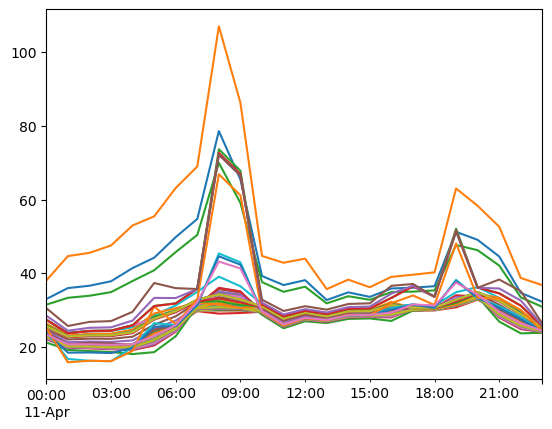

In [44]:
results_0_wo_esr['LMP'].plot(legend=False)

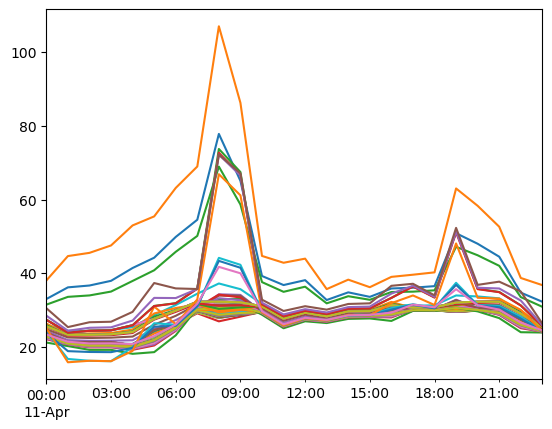

In [45]:
results_0_w_esr['LMP'].plot(legend=False)

### With initial conditions

In [46]:
# Only run for one day
d = d+1
start_datetime = timestamp_list[d]
end_datetime = start_datetime + timedelta(hours=23)
print(f'Start time: {start_datetime}')
print(f'End time: {end_datetime}')

Start time: 2018-04-12 00:00:00
End time: 2018-04-12 23:00:00


In [47]:
# Read MATPOWER case file
ppc_filename = os.path.join(data_dir, 'ny_grid.mat')

nygrid_sim_1_wo_esr = NYGrid(ppc_filename, 
                    start_datetime=start_datetime.strftime('%m-%d-%Y %H'), 
                    end_datetime=end_datetime.strftime('%m-%d-%Y %H'),
                    dcline_prop=dcline_prop,
                    esr_prop=None,
                    verbose=True)

# Set load and generation time series data
nygrid_sim_1_wo_esr.set_load_sch(load_profile)
nygrid_sim_1_wo_esr.set_gen_mw_sch(gen_profile)
nygrid_sim_1_wo_esr.set_gen_max_sch(genmax_profile)
nygrid_sim_1_wo_esr.set_gen_min_sch(genmin_profile)
nygrid_sim_1_wo_esr.set_gen_ramp_sch(genramp30_profile)
nygrid_sim_1_wo_esr.set_gen_cost_sch(gencost0_profile, gencost1_profile)

# Set generator initial condition
last_gen = results_0_wo_esr['PG'].iloc[-1,:].to_numpy().squeeze()
nygrid_sim_1_wo_esr.set_gen_init_data(gen_init=last_gen)

# Set options
options = {'UsePTDF': False,
           'solver': 'gurobi',
           'PenaltyForBranchMwViolation': 1e6,
           'PenaltyForInterfaceMWViolation': 1e6}
nygrid_sim_1_wo_esr.set_options(options)

# Solve DC OPF
nygrid_sim_1_wo_esr.solve_dc_opf()

# Get results
results_1_wo_esr = nygrid_sim_1_wo_esr.get_results_dc_opf()

Number of buses: 57
Number of generators: 279
Number of branches: 94
Number of time periods: 24
Number of variables: 30168
Number of constraints: 36912
Set parameter Username
Academic license - for non-commercial use only - expires 2024-07-12
Read LP format model from file C:\Users\xjtuy\AppData\Local\Temp\tmpogocsjms.pyomo.lp
Reading time = 0.08 seconds
x30169: 36913 rows, 30169 columns, 86035 nonzeros
Set parameter QCPDual to value 1
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 36913 rows, 30169 columns and 86035 nonzeros
Model fingerprint: 0xd67a566e
Coefficient statistics:
  Matrix range     [1e-01, 5e+02]
  Objective range  [8e+00, 1e+06]
  Bounds range     [6e+00, 6e+00]
  RHS range        [6e-17, 2e+04]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 30902 rows and 19775 columns
Presolve time: 0.06s
Presol

In [48]:
# Read MATPOWER case file
ppc_filename = os.path.join(data_dir, 'ny_grid.mat')

nygrid_sim_1_w_esr = NYGrid(ppc_filename, 
                    start_datetime=start_datetime.strftime('%m-%d-%Y %H'), 
                    end_datetime=end_datetime.strftime('%m-%d-%Y %H'),
                    dcline_prop=dcline_prop,
                    esr_prop=esr_prop,
                    verbose=True)

# Set load and generation time series data
nygrid_sim_1_w_esr.set_load_sch(load_profile)
nygrid_sim_1_w_esr.set_gen_mw_sch(gen_profile)
nygrid_sim_1_w_esr.set_gen_max_sch(genmax_profile)
nygrid_sim_1_w_esr.set_gen_min_sch(genmin_profile)
nygrid_sim_1_w_esr.set_gen_ramp_sch(genramp30_profile)
nygrid_sim_1_w_esr.set_gen_cost_sch(gencost0_profile, gencost1_profile)

# Set generator initial condition
last_gen = results_0_w_esr['PG'].iloc[-1,:].to_numpy().squeeze()
nygrid_sim_1_w_esr.set_gen_init_data(gen_init=last_gen)

# Set options
options = {'UsePTDF': False,
           'solver': 'gurobi',
           'PenaltyForBranchMwViolation': 1e6,
           'PenaltyForInterfaceMWViolation': 1e6}
nygrid_sim_1_w_esr.set_options(options)

# Solve DC OPF
nygrid_sim_1_w_esr.solve_dc_opf()

# Get results
results_1_w_esr = nygrid_sim_1_w_esr.get_results_dc_opf()

Number of buses: 57
Number of generators: 309
Number of branches: 94
Number of time periods: 24
Number of variables: 34488
Number of constraints: 44142
Set parameter Username
Academic license - for non-commercial use only - expires 2024-07-12
Read LP format model from file C:\Users\xjtuy\AppData\Local\Temp\tmpgcd4mwjy.pyomo.lp
Reading time = 0.11 seconds
x34489: 44143 rows, 34489 columns, 100375 nonzeros
Set parameter QCPDual to value 1
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 44143 rows, 34489 columns and 100375 nonzeros
Model fingerprint: 0x841f0696
Coefficient statistics:
  Matrix range     [1e-01, 5e+02]
  Objective range  [5e-01, 1e+06]
  Bounds range     [6e+00, 6e+00]
  RHS range        [6e-17, 2e+04]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 36790 rows and 21343 columns
Presolve time: 0.04s
Pres

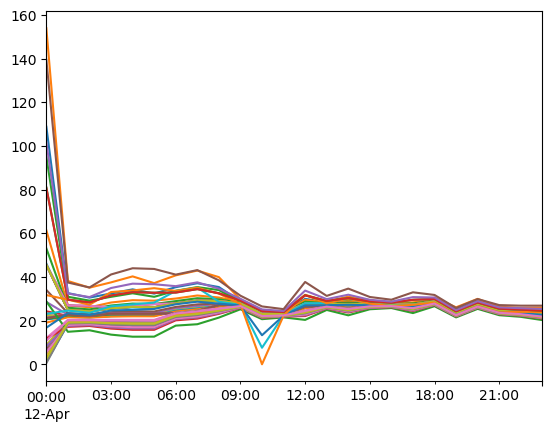

In [49]:
results_1_wo_esr['LMP'].plot(legend=False)

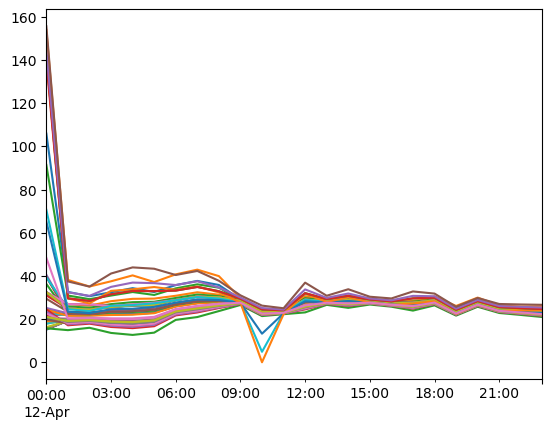

In [50]:
(results_1_w_esr['LMP']).plot(legend=False)

## Process the results

In [18]:
# Read thermal generator info table
filename = os.path.join(data_dir, 'genInfo.csv')
gen_info = pd.read_csv(filename)
num_thermal = gen_info.shape[0]
gen_rename = {gen_info.index[i]: gen_info.NYISOName[i] for i in range(num_thermal)}
gen_info

,NYISOName,PTID,Zone,UnitType,FuelType,Latitude,Longitude,maxPower,minPower,maxRampAgc,...,maxRamp60,HeatRateLM_1,HeatRateLM_0,HeatRateLM_R2,HeatRateQM_2,HeatRateQM_1,HeatRateQM_0,HeatRateQM_R2,useQM,start-time
0,59 St. GT 1,24138,J,Combustion Turbine,Kerosene,40.772385,-73.993028,17.1,0.0,1.710000,...,17.1,13.315000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,10m
1,74 St. GT 1,24260,J,Combustion Turbine,Kerosene,40.768421,-73.951731,18.5,0.0,1.850000,...,18.5,13.315000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,10m
2,74 St. GT 2,24261,J,Combustion Turbine,Kerosene,40.768421,-73.951731,18.5,0.0,1.850000,...,18.5,13.315000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,10m
3,Allegany,23514,B,Combined Cycle,Natural Gas,42.508300,-78.066100,66.0,11.0,6.600000,...,66.0,8.218122,-14.577671,0.862443,-0.094773,15.209040,-125.857658,0.891407,1,10m
4,Allied Frozen Storage,23774,A,Internal Combustion,Natural Gas,42.842029,-78.722673,0.1,0.0,0.010000,...,0.1,8.899000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,10m
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222,Vernon Blvd 3,24163,J,Combustion Turbine,Natural Gas,40.753900,-73.950600,42.0,15.0,0.558333,...,33.5,17.272897,-319.572736,0.893510,0.524043,-14.979198,132.238854,0.935802,1,over
223,Wading River 1,23522,K,Combustion Turbine,Fuel Oil 2,40.956900,-72.877400,102.0,9.0,1.258333,...,75.5,12.779330,-5.232355,0.960069,-0.051615,18.026301,-96.225639,0.967170,1,over
224,Wading River 2,23547,K,Combustion Turbine,Fuel Oil 2,40.956900,-72.877400,94.0,7.8,1.350000,...,81.0,13.381103,-32.778267,0.981323,-0.027035,15.957351,-73.206752,0.982889,1,over
225,Wading River 3,23601,K,Combustion Turbine,Fuel Oil 2,40.956900,-72.877400,94.0,4.0,1.333333,...,80.0,12.154083,-11.601042,0.822005,-0.022269,14.190789,-39.250293,0.821057,1,over


In [19]:
# Format results
results_pg_0_wo_esr = results_0_wo_esr['PG']
thermal_pg_0_wo_esr = results_pg_0_wo_esr.iloc[:, :num_thermal]
thermal_pg_0_wo_esr = thermal_pg_0_wo_esr.rename(columns=gen_rename)
print(thermal_pg_0_wo_esr.head())

results_pg_0_w_esr = results_0_w_esr['PG']
thermal_pg_0_w_esr = results_pg_0_w_esr.iloc[:, :num_thermal]
thermal_pg_0_w_esr = thermal_pg_0_w_esr.rename(columns=gen_rename)
print(thermal_pg_0_w_esr.head())

results_pg_1_wo_esr = results_1_wo_esr['PG']
thermal_pg_1_wo_esr = results_pg_1_wo_esr.iloc[:, :num_thermal]
thermal_pg_1_wo_esr = thermal_pg_1_wo_esr.rename(columns=gen_rename)
print(thermal_pg_1_wo_esr.head())

results_pg_1_w_esr = results_1_w_esr['PG']
thermal_pg_1_w_esr = results_pg_1_w_esr.iloc[:, :num_thermal]
thermal_pg_1_w_esr = thermal_pg_1_w_esr.rename(columns=gen_rename)
print(thermal_pg_1_w_esr.head())

                     59 St.  GT 1  74 St.  GT 1  74 St.  GT 2  Allegany  \
2018-01-01 00:00:00           0.0           0.0           0.0      66.0   
2018-01-01 01:00:00           0.0           0.0           0.0      66.0   
2018-01-01 02:00:00           0.0           0.0           0.0      66.0   
2018-01-01 03:00:00           0.0           0.0           0.0      66.0   
2018-01-01 04:00:00           0.0           0.0           0.0      66.0   

                     Allied Frozen Storage  Arthur Kill Cogen  \
2018-01-01 00:00:00                    0.1               11.1   
2018-01-01 01:00:00                    0.1               11.1   
2018-01-01 02:00:00                    0.1               11.1   
2018-01-01 03:00:00                    0.1               11.1   
2018-01-01 04:00:00                    0.1               11.1   

                     Arthur Kill GT 1  Arthur Kill ST 2  Arthur Kill ST 3  \
2018-01-01 00:00:00               0.0             349.0             539.0   
2018

In [20]:
def plot_gen(thermal_pg, gen_profile, genmax_profile, genmin_profile, i, title=None, ax=None):

    ax.plot(thermal_pg.index, thermal_pg.iloc[:, i], marker='*', label='OPF')
    ax.plot(thermal_pg.index, gen_profile[start_datetime:end_datetime].iloc[:,i], marker='o', label='historical')
    ax.plot(thermal_pg.index, genmax_profile[start_datetime:end_datetime].iloc[:,i], linestyle='--', label='max')
    ax.plot(thermal_pg.index, genmin_profile[start_datetime:end_datetime].iloc[:,i], linestyle='--', label='min')
    ax.legend()
    ax.set_title(title)

    return ax

NYISOName              Allegany
PTID                      23514
Zone                          B
UnitType         Combined Cycle
FuelType            Natural Gas
Latitude                42.5083
Longitude              -78.0661
maxPower                   66.0
minPower                   11.0
maxRampAgc                  6.6
maxRamp10                  66.0
maxRamp30                  66.0
maxRamp60                  66.0
HeatRateLM_1           8.218122
HeatRateLM_0         -14.577671
HeatRateLM_R2          0.862443
HeatRateQM_2          -0.094773
HeatRateQM_1           15.20904
HeatRateQM_0        -125.857658
HeatRateQM_R2          0.891407
useQM                         1
start-time                  10m
Name: 3, dtype: object


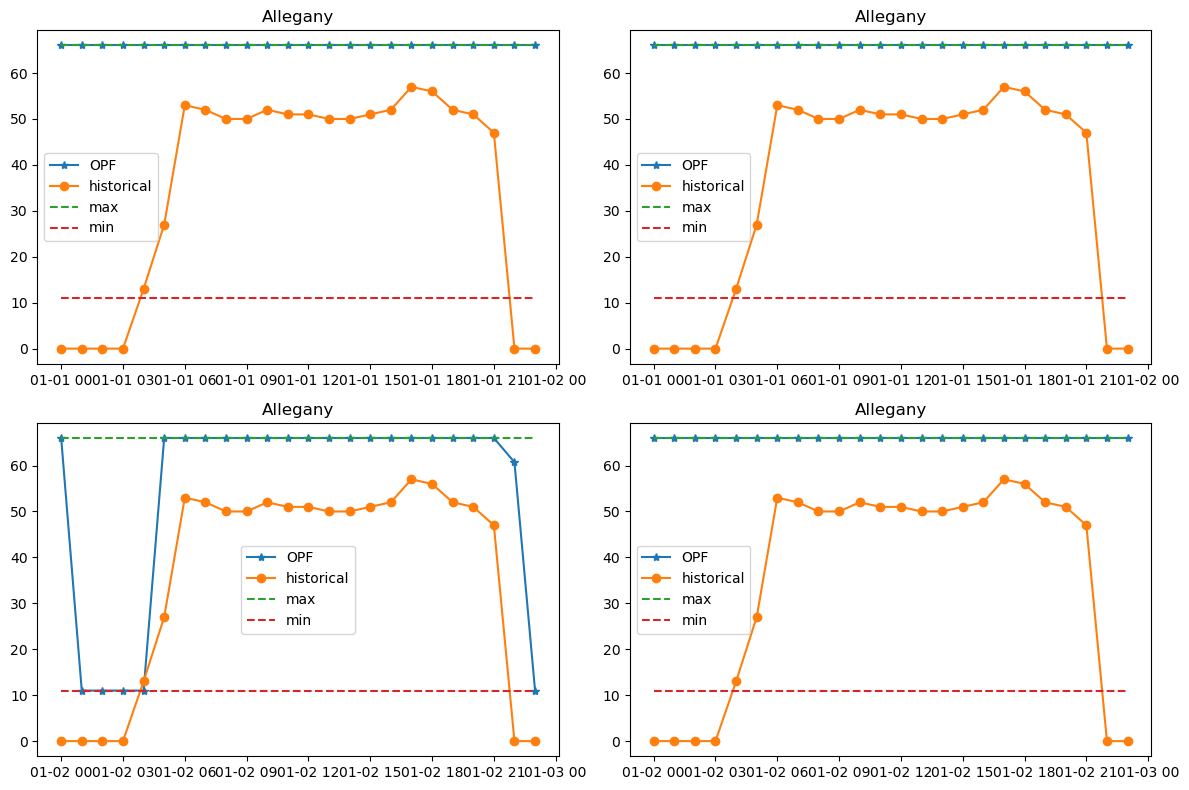

In [21]:
ii = 3
print(gen_info.iloc[ii, :])
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs[0, 0] = plot_gen(thermal_pg_0_wo_esr, gen_profile, genmax_profile, genmin_profile, ii, title=gen_info.NYISOName[ii], ax=axs[0, 0])
axs[0, 1] = plot_gen(thermal_pg_0_w_esr, gen_profile, genmax_profile, genmin_profile, ii, title=gen_info.NYISOName[ii], ax=axs[0, 1])
axs[1, 0] = plot_gen(thermal_pg_1_wo_esr, gen_profile, genmax_profile, genmin_profile, ii, title=gen_info.NYISOName[ii], ax=axs[1, 0])
axs[1, 1] = plot_gen(thermal_pg_1_w_esr, gen_profile, genmax_profile, genmin_profile, ii, title=gen_info.NYISOName[ii], ax=axs[1, 1])
fig.tight_layout()

NYISOName            Astoria 2
PTID                     24149
Zone                         J
UnitType         Steam Turbine
FuelType           Natural Gas
Latitude               40.7869
Longitude             -73.9122
maxPower                 153.0
minPower                   1.0
maxRampAgc                15.3
maxRamp10                153.0
maxRamp30                153.0
maxRamp60                153.0
HeatRateLM_1         10.720159
HeatRateLM_0        147.545513
HeatRateLM_R2         0.987563
HeatRateQM_2          0.007555
HeatRateQM_1          9.621049
HeatRateQM_0        170.560114
HeatRateQM_R2          0.98891
useQM                        1
start-time                 10m
Name: 9, dtype: object


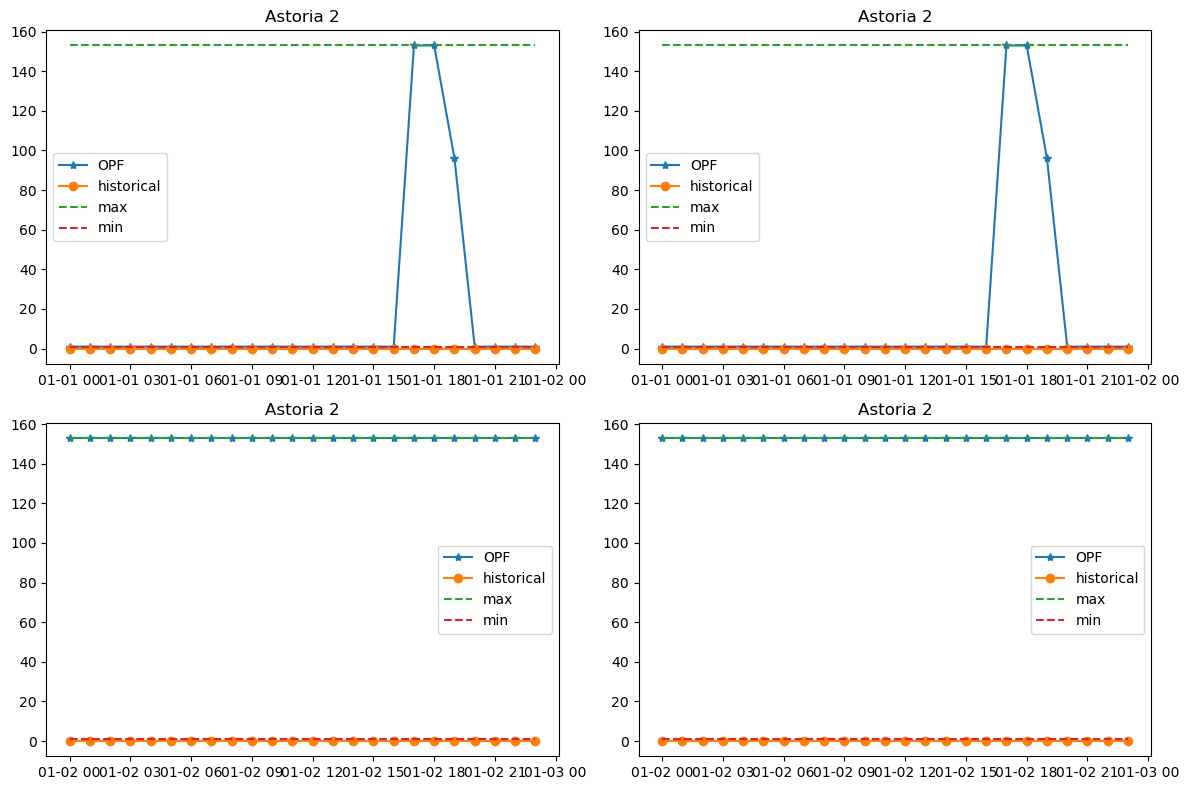

In [22]:
ii = 9
print(gen_info.iloc[ii, :])
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs[0, 0] = plot_gen(thermal_pg_0_wo_esr, gen_profile, genmax_profile, genmin_profile, ii, title=gen_info.NYISOName[ii], ax=axs[0, 0])
axs[0, 1] = plot_gen(thermal_pg_0_w_esr, gen_profile, genmax_profile, genmin_profile, ii, title=gen_info.NYISOName[ii], ax=axs[0, 1])
axs[1, 0] = plot_gen(thermal_pg_1_wo_esr, gen_profile, genmax_profile, genmin_profile, ii, title=gen_info.NYISOName[ii], ax=axs[1, 0])
axs[1, 1] = plot_gen(thermal_pg_1_w_esr, gen_profile, genmax_profile, genmin_profile, ii, title=gen_info.NYISOName[ii], ax=axs[1, 1])
fig.tight_layout()


NYISOName           EMPIRE_CC_2
PTID                     323658
Zone                          F
UnitType         Combined Cycle
FuelType            Natural Gas
Latitude                42.6296
Longitude               -73.749
maxPower                  327.0
minPower                  159.0
maxRampAgc                3.125
maxRamp10                 31.25
maxRamp30                 93.75
maxRamp60                 187.5
HeatRateLM_1           6.613482
HeatRateLM_0          112.15103
HeatRateLM_R2           0.97822
HeatRateQM_2           0.008103
HeatRateQM_1           2.913671
HeatRateQM_0         520.066758
HeatRateQM_R2          0.980529
useQM                         1
start-time                  12h
Name: 83, dtype: object


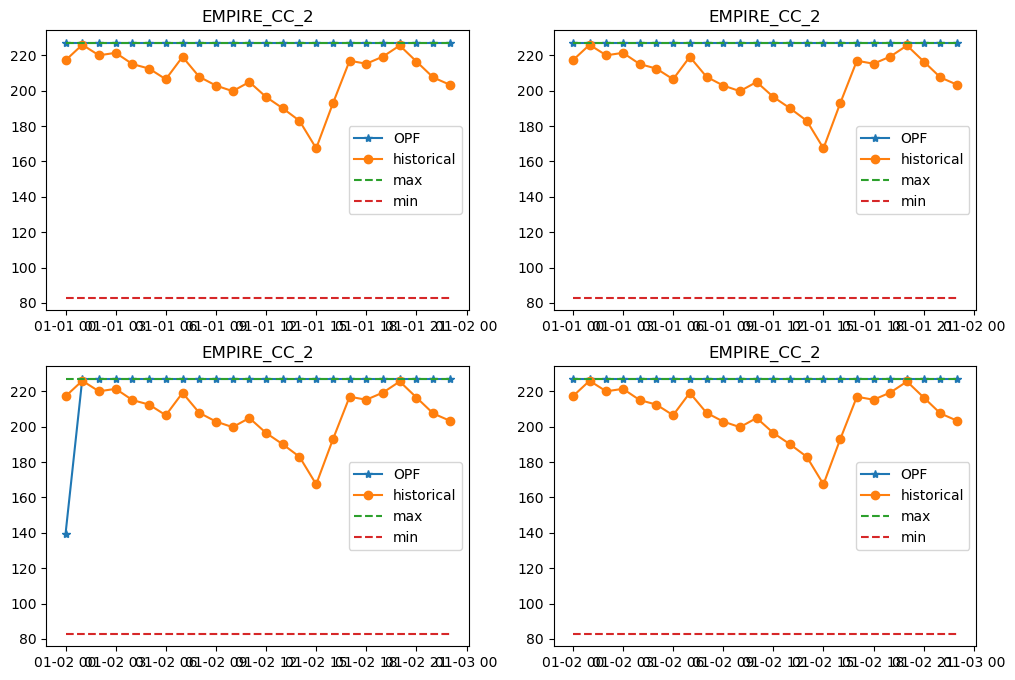

In [23]:
ii = 83
print(gen_info.iloc[ii, :])
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs[0, 0] = plot_gen(thermal_pg_0_wo_esr, gen_profile, genmax_profile, genmin_profile, ii, title=gen_info.NYISOName[ii], ax=axs[0, 0])
axs[0, 1] = plot_gen(thermal_pg_0_w_esr, gen_profile, genmax_profile, genmin_profile, ii, title=gen_info.NYISOName[ii], ax=axs[0, 1])
axs[1, 0] = plot_gen(thermal_pg_1_wo_esr, gen_profile, genmax_profile, genmin_profile, ii, title=gen_info.NYISOName[ii], ax=axs[1, 0])
axs[1, 1] = plot_gen(thermal_pg_1_w_esr, gen_profile, genmax_profile, genmin_profile, ii, title=gen_info.NYISOName[ii], ax=axs[1, 1])
plt.show()